CELL 1: chuẩn hóa toàn bộ dữ liệu 


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 1. Đọc dữ liệu từ file gốc
df = pd.read_csv('Iris.csv')

# 2. Lấy 4 đặc trưng gốc (bỏ Id, Species)
features = df.drop(columns=['Id', 'Species'])

# 3. Biến 4 đặc trưng thành 2 đặc trưng (ví dụ ghép cặp hoặc kết hợp tuyến tính)
# Ở đây ta lấy trung bình 2 nhóm làm ví dụ
df['Feature1'] = (df['SepalLengthCm'] + df['SepalWidthCm']) / 2
df['Feature2'] = (df['PetalLengthCm'] + df['PetalWidthCm']) / 2

# 4. Chỉ lấy 2 đặc trưng mới để chuẩn hóa
features_2d = df[['Feature1', 'Feature2']]

# 5. Chuẩn hóa dữ liệu về khoảng [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler.fit_transform(features_2d)

# 6. Tạo DataFrame mới chứa dữ liệu chuẩn hóa
normalized_df = pd.DataFrame(features_scaled, columns=['Feature1', 'Feature2'])
normalized_df['Species'] = df['Species']
normalized_df.insert(0, 'Id', df['Id'])

# 7. Lưu ra file CSV
normalized_df.to_csv('Iris_2features_normalized.csv', index=False)

print(" Đã tạo file Iris_2features_normalized.csv với 2 đặc trưng chuẩn hóa trong khoảng [0, 1]")


✅ Đã tạo file Iris_2features_normalized.csv với 2 đặc trưng chuẩn hóa trong khoảng [0, 1]


In [31]:
import pandas as pd
import os

# đọc dữ liệu từ file đã chuẩn hóa
df = pd.read_csv('Iris_2features_normalized.csv')

# tạo thư mục để lưu các file mới nếu chưa tồn tại
base_dir = "iris_folder"
os.makedirs(base_dir, exist_ok=True)

# Định nghĩa các nhóm ID cho từng folder
folder_ranges = {
    1: list(range(1, 11)) + list(range(51, 61)) + list(range(101, 111)),
    2: list(range(11, 21)) + list(range(61, 71)) + list(range(111, 121)),
    3: list(range(21, 31)) + list(range(71, 81)) + list(range(121, 131)),
    4: list(range(31, 41)) + list(range(81, 91)) + list(range(131, 141)),
    5: list(range(41, 51)) + list(range(91, 101)) + list(range(141, 151))
}

# Lặp qua từng folder và lưu dữ liệu tương ứng
for folder_num, ids in folder_ranges.items():
    folder_path = os.path.join(base_dir, f"folder_{folder_num}")
    os.makedirs(folder_path, exist_ok=True)

    subset = df[df['Id'].isin(ids)]
    subset.to_csv(os.path.join(folder_path, f"iris_part_{folder_num}.csv"), index=False)

    print(f"Đã tạo folder_{folder_num} với {len(subset)} mẫu.")

print("Hoàn tất chia dữ liệu thành 5 folder.")

Đã tạo folder_1 với 30 mẫu.
Đã tạo folder_2 với 30 mẫu.
Đã tạo folder_3 với 30 mẫu.
Đã tạo folder_4 với 30 mẫu.
Đã tạo folder_5 với 30 mẫu.
Hoàn tất chia dữ liệu thành 5 folder.


In [32]:
import pandas as pd
import numpy as np
import os

# === Hàm tính khoảng cách Manhattan ===
def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

# === Hàm dự đoán class gần nhất ===
def predict_label(test_sample, train_features, train_labels):
    distances = [manhattan_distance(test_sample, train_features.iloc[i]) for i in range(len(train_features))]
    nearest_index = np.argmin(distances)
    return train_labels.iloc[nearest_index]

# === Thư mục dữ liệu và thư mục kết quả ===
base_dir = "/media/pphong/D:/ML & DL/ML/AI_02/iris_folder"
result_dir = "/media/pphong/D:/ML & DL/ML/AI_02/result_folder"
os.makedirs(result_dir, exist_ok=True)

# === Danh sách folder ===
folders = [f"folder_{i}" for i in range(1, 6)]
results = []   # Lưu accuracy từng lần

# === Chạy 5 lần (5-fold) ===
for test_folder in folders:
    print(f"\n===== Test với {test_folder} =====")

    # Test data
    test_path = os.path.join(base_dir, test_folder)
    test_csv = [f for f in os.listdir(test_path) if f.endswith('.csv')]
    if not test_csv:
        raise FileNotFoundError(f"Không tìm thấy file CSV trong {test_path}")
    test_df = pd.read_csv(os.path.join(test_path, test_csv[0]))

    # Train data (4 folder còn lại)
    train_folders = [f for f in folders if f != test_folder]
    train_dfs = []
    for f in train_folders:
        csvs = [c for c in os.listdir(os.path.join(base_dir, f)) if c.endswith('.csv')]
        if not csvs:
            raise FileNotFoundError(f"Không tìm thấy CSV trong {f}")
        train_dfs.append(pd.read_csv(os.path.join(base_dir, f, csvs[0])))
    train_df = pd.concat(train_dfs, ignore_index=True)

    # Chuẩn hóa dữ liệu (0–1) theo tập train
    X_train = train_df.drop(columns=['Id', 'Species'])
    y_train = train_df['Species']
    X_test = test_df.drop(columns=['Id', 'Species'])
    y_test = test_df['Species']

    X_train_norm = (X_train - X_train.min()) / (X_train.max() - X_train.min())
    X_test_norm = (X_test - X_train.min()) / (X_train.max() - X_train.min())

    # Dự đoán
    predictions = [predict_label(X_test_norm.iloc[i], X_train_norm, y_train) 
                   for i in range(len(X_test_norm))]

    # Đánh giá
    accuracy = np.mean(np.array(predictions) == np.array(y_test))
    results.append(accuracy)
    print(f"Accuracy = {accuracy:.3f}")

    # Lưu file kết quả vào result_folder
    result_df = test_df.copy()
    result_df['Predicted'] = predictions
    result_path = os.path.join(result_dir, f"result_{test_folder}.csv")
    result_df.to_csv(result_path, index=False)
    print(f"Đã lưu: {result_path}")

# === Tổng kết ===
print("\n=== KẾT QUẢ 5-FOLD CROSS-VALIDATION ===")
for i, acc in enumerate(results, 1):
    print(f"Fold {i}: Accuracy = {acc:.3f}")
print(f"Mean accuracy = {np.mean(results):.3f}")



===== Test với folder_1 =====
Accuracy = 1.000
Đã lưu: /media/pphong/D:/ML & DL/ML/AI_02/result_folder/result_folder_1.csv

===== Test với folder_2 =====
Accuracy = 0.967
Đã lưu: /media/pphong/D:/ML & DL/ML/AI_02/result_folder/result_folder_2.csv

===== Test với folder_3 =====
Accuracy = 0.933
Đã lưu: /media/pphong/D:/ML & DL/ML/AI_02/result_folder/result_folder_3.csv

===== Test với folder_4 =====
Accuracy = 0.933
Đã lưu: /media/pphong/D:/ML & DL/ML/AI_02/result_folder/result_folder_4.csv

===== Test với folder_5 =====
Accuracy = 1.000
Đã lưu: /media/pphong/D:/ML & DL/ML/AI_02/result_folder/result_folder_5.csv

=== KẾT QUẢ 5-FOLD CROSS-VALIDATION ===
Fold 1: Accuracy = 1.000
Fold 2: Accuracy = 0.967
Fold 3: Accuracy = 0.933
Fold 4: Accuracy = 0.933
Fold 5: Accuracy = 1.000
Mean accuracy = 0.967



===== Test với folder_1 =====
✅ Accuracy = 1.000


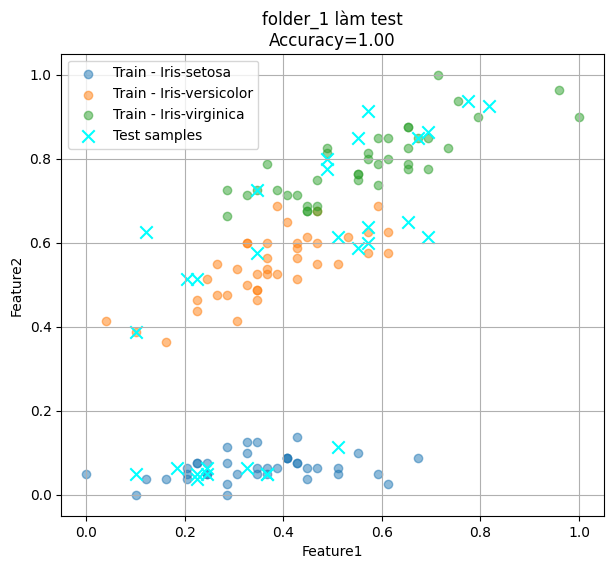


===== Test với folder_2 =====
✅ Accuracy = 0.967


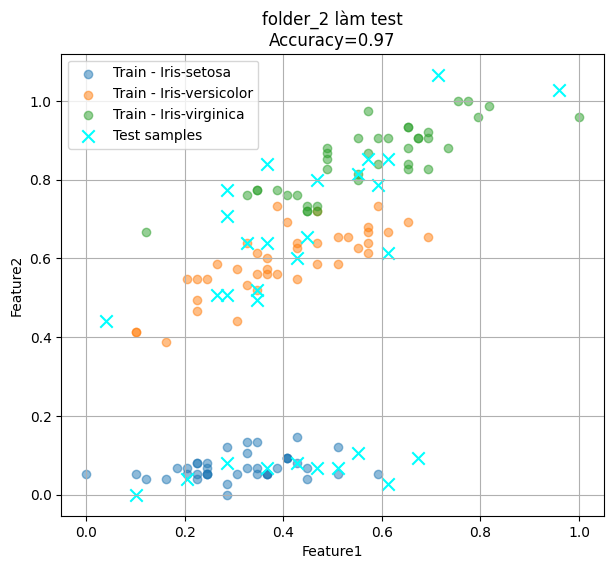


===== Test với folder_3 =====
✅ Accuracy = 0.933


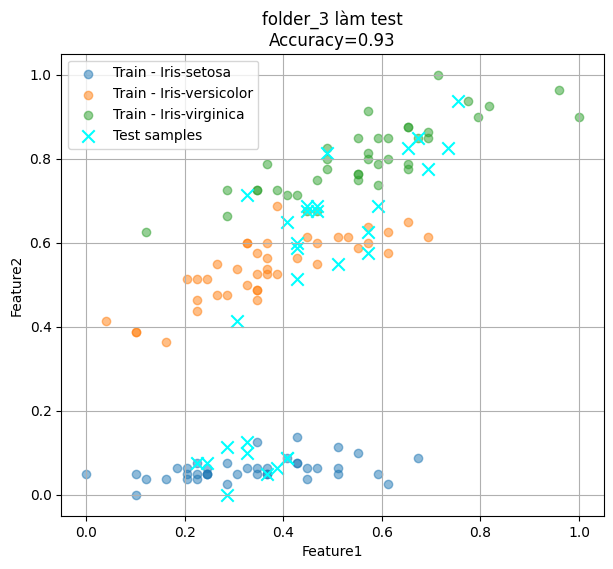


===== Test với folder_4 =====
✅ Accuracy = 0.933


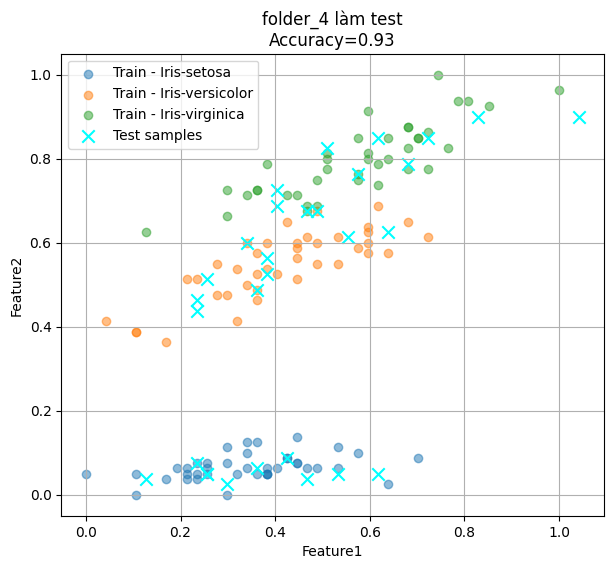


===== Test với folder_5 =====
✅ Accuracy = 1.000


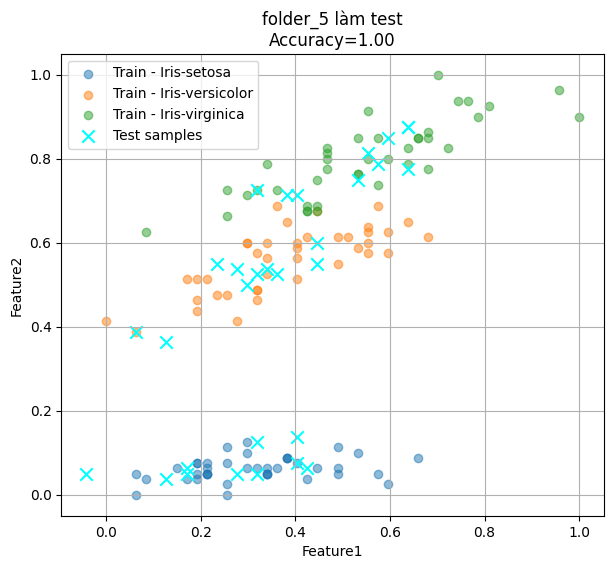

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# === Cấu hình ===
base_dir = r"/media/pphong/D:/ML & DL/ML/AI_02/iris_folder"   # Đúng thư mục
folders = [f"folder_{i}" for i in range(1, 6)]
features = ["Feature1", "Feature2"]

def manhattan_distance(a, b):
    return np.sum(np.abs(a - b))

# === Cross-validation 5 lần ===
for test_folder in folders:
    print(f"\n===== Test với {test_folder} =====")

    # Train data (ghép từ 4 folder còn lại)
    train_folders = [f for f in folders if f != test_folder]
    train_dfs = []
    for f in train_folders:
        folder_path = os.path.join(base_dir, f)
        csvs = [c for c in os.listdir(folder_path) if c.endswith(".csv")]
        if not csvs:
            raise FileNotFoundError(f"Không có CSV trong {folder_path}")
        train_dfs.append(pd.read_csv(os.path.join(folder_path, csvs[0])))
    train_df = pd.concat(train_dfs, ignore_index=True)

    # Test data
    test_path = os.path.join(base_dir, test_folder)
    test_csvs = [c for c in os.listdir(test_path) if c.endswith(".csv")]
    if not test_csvs:
        raise FileNotFoundError(f"Không có CSV trong {test_path}")
    test_df = pd.read_csv(os.path.join(test_path, test_csvs[0]))

    # Chuẩn hoá theo train
    min_vals = train_df[features].min()
    max_vals = train_df[features].max()
    train_df[features] = (train_df[features] - min_vals) / (max_vals - min_vals)
    test_df[features] = (test_df[features] - min_vals) / (max_vals - min_vals)

    # Template Matching
    preds = []
    for _, row in test_df.iterrows():
        test_feat = row[features].values
        dists = [(manhattan_distance(test_feat, tr[features].values), tr["Species"]) 
                 for _, tr in train_df.iterrows()]
        preds.append(min(dists, key=lambda x: x[0])[1])
    test_df["Predicted"] = preds

    # Accuracy
    acc = np.mean(test_df["Predicted"] == test_df["Species"])
    print(f"Accuracy = {acc:.3f}")

    # Vẽ scatter
    plt.figure(figsize=(7,6))
    for sp in train_df["Species"].unique():
        subset = train_df[train_df["Species"] == sp]
        plt.scatter(subset["Feature1"], subset["Feature2"], label=f"Train - {sp}", alpha=0.5)

    plt.scatter(test_df["Feature1"], test_df["Feature2"], c="cyan", marker="x", s=80, label="Test samples")
    plt.xlabel("Feature1")
    plt.ylabel("Feature2")
    plt.title(f"{test_folder} làm test\nAccuracy={acc:.2f}")
    plt.legend()
    plt.grid(True)
    plt.show()
